In [1]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib import cm
import xarray as xr
import pandas as pd
import datetime
import warnings # Silence the warnings from SHARPpy
warnings.filterwarnings("ignore")
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import scipy
#import pymeteo.skewt as skewt
import cProfile
import math
from metpy.interpolate import cross_section
from shapely.geometry import Polygon, Point
import cmweather
#import proplot as pplt
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import measure
from skimage.draw import ellipse, polygon, polygon_perimeter
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage import data, io, segmentation, color
from skimage.color import label2rgb
import matplotlib.patches as mpatches
import plotly
import plotly.express as px
import plotly.graph_objects as go
from shapely.validation import make_valid
from sharppy.sharptab import winds, utils, params, thermo, interp, profile
from sharppy.io.spc_decoder import SPCDecoder
import sharppy.plot.skew as skew

import metpy.calc as mpcalc
from metpy.units import units

from matplotlib.ticker import ScalarFormatter, MultipleLocator
from matplotlib.collections import LineCollection
import matplotlib.transforms as transforms
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sharppy.sharptab as tab
from matplotlib import gridspec

import shapely
import shapely.plotting
import shapely.wkt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
#Modify the Skew-T's to put them into CM1

cordoba = xr.open_dataset('/data/keeling/a/melinda3/NASA/uiucformat_nc_1.3/Cordoba_griddedsounding.nc')
cordoba = cordoba.rename({'launch time':'launch_time'})

skews  = cordoba.sel(launch_time = slice('2018-11-10 20:00', '2018-11-10 20:10'))


In [3]:
launch = np.arange(len(skews.launch_time))
obs_temp = np.flip(np.array(skews.Temp[launch, :])).flatten()
obs_dew = np.flip(np.array(skews.Dewpt[launch, :])).flatten()
obs_pres = np.flip(np.array(skews.pressure[:])).flatten()
obs_ucomp = np.flip(np.array(skews.Ucmp[launch, :])).flatten()
obs_vcomp = np.flip(np.array(skews.Vcmp[launch, :])).flatten()
obs_alt = np.flip(np.array(skews.Alt[launch,:])).flatten()
lalt = skews.lalt[launch].values
lat = np.flip(np.array(skews.Lat[launch, :])).flatten()
lon = np.flip(np.array(skews.Lon[launch, :])).flatten()

skews.launch_time

<xarray.DataArray 'launch_time' (launch_time: 1)>
array(['2018-11-10T20:04:04.000000000'], dtype='datetime64[ns]')
Coordinates:
  * launch_time  (launch_time) datetime64[ns] 2018-11-10T20:04:04

In [4]:
obs_temp_nan = (~np.isnan(obs_temp))

obs_temp = obs_temp[obs_temp_nan]
obs_pres = obs_pres[obs_temp_nan]
obs_dew = obs_dew[obs_temp_nan]
obs_ucomp = obs_ucomp[obs_temp_nan] * units.meter/units.second
obs_vcomp = obs_vcomp[obs_temp_nan] * units.meter/units.second
obs_alt = obs_alt[obs_temp_nan]

obs_alt_nan = (~np.isnan(obs_alt))
obs_temp = obs_temp[obs_alt_nan]*units.degC
obs_pres = obs_pres[obs_alt_nan]*units.hectopascal
obs_dew = obs_dew[obs_alt_nan] * units.degC
obs_ucomp = obs_ucomp[obs_alt_nan]
obs_vcomp = obs_vcomp[obs_alt_nan]
obs_alt  = obs_alt[obs_alt_nan] * units.meter


wnddir = mpcalc.wind_direction(obs_ucomp, obs_vcomp, convention="from")
wndspd = mpcalc.wind_speed(obs_ucomp, obs_vcomp)

wndspd_kts = wndspd.to(units.kts)

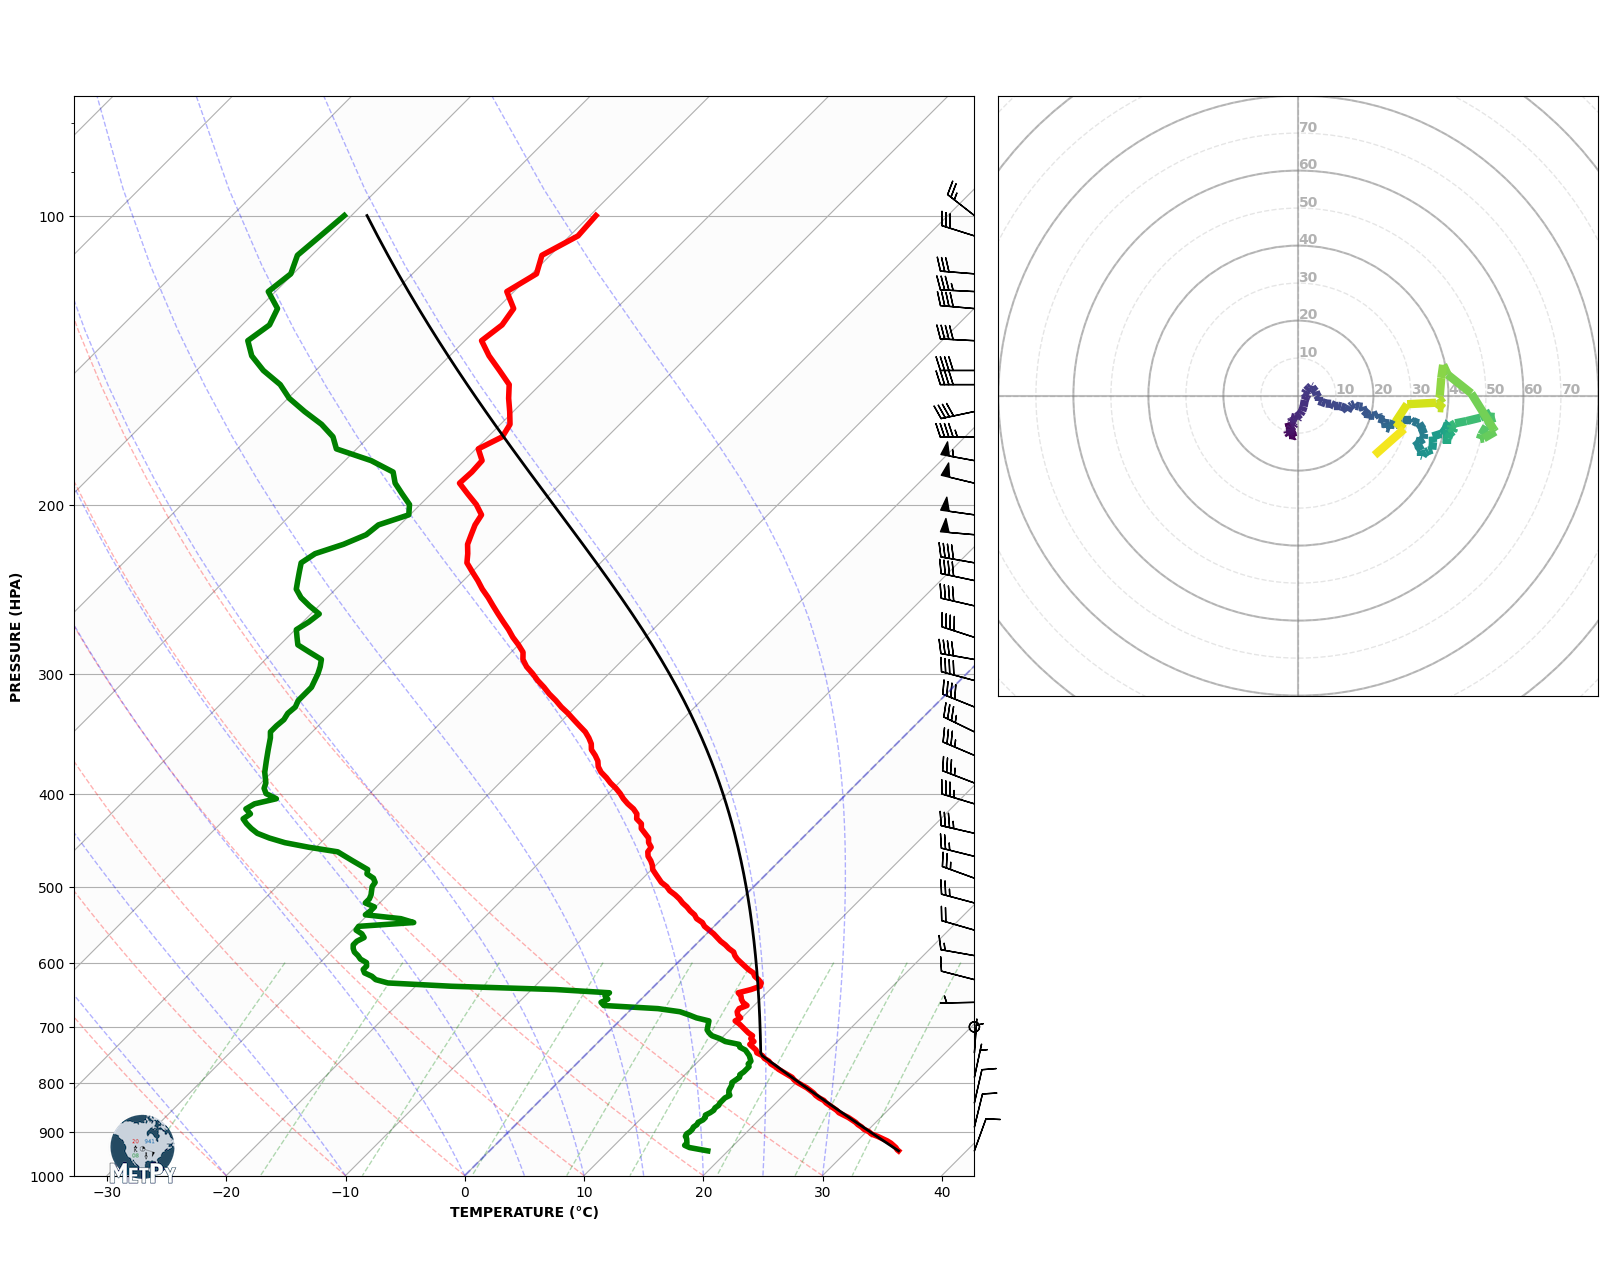

In [5]:
#Plot the unchanged sounding

# STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A
# NICE, CLEAN PLOT
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))

# add the Metpy logo
add_metpy_logo(fig, 105, 85, size='small')

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 75)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({obs_temp.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({obs_pres.units:~P})'), weight='bold')

# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO
# INCREASE READABILITY
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# Set the linewidth to 4 for increased readability.
# We will also add the 'label' keyword argument for our legend.
skew.plot(obs_pres, obs_temp, 'r', lw=4, label='TEMPERATURE')
skew.plot(obs_pres, obs_dew, 'g', lw=4, label='DEWPOINT')

# Again we can use some simple Python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability.
# Something like this would work.
interval = np.logspace(2, 3, 40) * units.hPa
idx = mpcalc.resample_nn_1d(obs_pres, interval)
skew.plot_barbs(pressure=obs_pres[idx], u=obs_ucomp[idx], v=obs_vcomp[idx])

# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first, we add a matplotlib axvline to highlight the 0-degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as a black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from a low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(obs_pres, obs_temp[0], obs_dew[0]).to('degC')
skew.plot(obs_pres, prof, 'k', linewidth=2, label='SB PARCEL PATH')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td, alpha=0.2, label='SBCIN')
#skew.shade_cape(p, T, prof, alpha=0.2, label='SBCAPE')

# STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO
# INCREASE READABILITY
# Create a hodograph object: first we need to add an axis
# then we can create the Metpy Hodograph
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)

# Add two separate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(obs_ucomp, obs_vcomp, c=obs_alt, linewidth=6, label='0-12km WIND')



In [6]:
#Filter the RH values throughout the sounding
rh = mpcalc.relative_humidity_from_dewpoint(obs_temp, obs_dew)

rh90 = np.where(rh >= 0.75)
dew_mag = obs_dew.magnitude
dew_mag[rh90] = dew_mag[rh90] - 5

obs_dew = dew_mag*units.degC

rh_updated = mpcalc.relative_humidity_from_dewpoint(obs_temp, obs_dew)

In [7]:
#Calculate theta for the entire profile
theta = mpcalc.potential_temperature(obs_pres, obs_temp)
theta = theta

#Calculate mixing ratio for the profile
mix_rat = mpcalc.mixing_ratio_from_relative_humidity(obs_pres, obs_temp,\
                                                     rh_updated).to('g/kg')


In [8]:
#Get the EL
sfc_p, sfc_t, sfc_td, _ = mpcalc.most_unstable_parcel(obs_pres, obs_temp, obs_dew, height = obs_alt)
mucape, mucin = mpcalc.most_unstable_cape_cin(obs_pres, obs_temp, obs_dew)

el_pressure, e_temperature = mpcalc.el(obs_pres, obs_temp, obs_dew)

In [9]:
def find_nearest(array, value):
    array = np.asarray(array)
    step = (np.abs(array-value))
    idx = np.nanargmin(step)

    return array[idx], idx

In [10]:
#Modify the UTLS to be a line with constant slope
pres, pidx = find_nearest(obs_pres, el_pressure.magnitude)
temp_til = obs_temp[:pidx]
t_min =  np.min(temp_til)
t, tidx = find_nearest(obs_temp, obs_temp[pidx].magnitude)

p_trop = obs_pres[pidx].magnitude
t_top = obs_temp[-1].magnitude
p_top  = obs_pres[-1].magnitude

mean_slope = (p_top - p_trop)/(t_top - t)

#Get points along the line
b = p_trop - (mean_slope* t_min.magnitude)
p_new = obs_pres[pidx:]
t_new = (p_new.magnitude - b)/(mean_slope)
t_new = t_new*units.degC

temp_same = obs_temp[:pidx]
mod_temp = np.append(temp_same, t_new)

In [11]:
#Modify the temperature profile to be more or less stable
mean_slope_warmer = mean_slope - 3
b = p_trop - (mean_slope_warmer * t_min.magnitude)

t_warmer = (p_new.magnitude - b) / (mean_slope_warmer)

#Modify the dewpoint profile in the LS to ensure that RH stays the same across different runs
rh_ls = rh[pidx:]
dew_new_more = mpcalc.dewpoint_from_relative_humidity(t_warmer*units.degC, rh_ls)

obs_dew_same = obs_dew[:pidx]
obs_dew_more = np.append(obs_dew_same, dew_new_more)

obs_temp_same = mod_temp[:pidx]
obs_temp_warmer = np.append(obs_temp_same, t_warmer*units.degC)

In [12]:
#Extrapolate the profiles to beyond the top of the model
alt_extrap = np.arange(obs_alt[-1].magnitude, 25000, 500)
p_ext = mpcalc.height_to_pressure_std(alt_extrap*units.meter)
temp_ext = np.full((1, len(alt_extrap)), obs_temp_warmer[-1].magnitude)
dew_ext = np.full((1, len(alt_extrap)), obs_dew_more[-1].magnitude)
u_ext = np.full((1, len(alt_extrap)), obs_ucomp[-1].magnitude) 
v_ext = np.full((1, len(alt_extrap)), obs_vcomp[-1].magnitude)


alt_extr = np.append(obs_alt[:-1].magnitude, alt_extrap)*units.meter
temp_extr = np.append(obs_temp_warmer[:-1].magnitude, temp_ext)*units.degC
u_extr = np.append(obs_ucomp[:-1].magnitude, u_ext)*units.meter_per_second
v_extr = np.append(obs_vcomp[:-1].magnitude, v_ext)*units.meter_per_second
dew_extr = np.append(obs_dew_more[:-1].magnitude, dew_ext)*units.degC 
pres_extr = np.append(obs_pres[:-1].magnitude, p_ext.magnitude)*units.mbar

In [ ]:
#Calculate theta and mixing ratio from modified profile
theta_extr = mpcalc.potential_temperature(pres_extr, temp_extr)
rh_extrap = mpcalc.relative_humidity_from_dewpoint(temp_extr, dew_extr)
##NB: this calculation is only e/es so makes an assumption of liquid phase only
mix_rat_extr = mpcalc.mixing_ratio_from_relative_humidity(pres_extr, temp_extr, rh_extrap).to('g/kg')

In [26]:
lss_dsh = xr.open_dataset('/data/keeling/a/melinda3/NASA/cm1_radiation/temp_cm1_dir/hodo_test_10_35_1m_lss_full/cm1out_000001.nc')
dss_dsh = xr.open_dataset('/data/keeling/a/melinda3/NASA/cm1_radiation/temp_cm1_dir/hodo_test_8_33_1m_dss_full/cm1out_000001.nc')
hss_dsh = xr.open_dataset('/data/keeling/a/melinda3/NASA/cm1_radiation/temp_cm1_dir/hodo_test_6_29_1m_hss_full/cm1out_000001.nc')

In [ ]:
theta_lo = lss_dsh.th[0,:,0,0].values*units.kelvin
qv_lo = lss_dsh.qv[0,:,0,0].values*units.kg/units.kg
prs_lo = lss_dsh.prs[0,:,0,0].values*units.pascal
hgt_lo = lss_dsh.zh.values*1000*units.meters
uint_lo = lss_dsh.uinterp[0,:,0,0].values*units.meter_per_second
vint_lo = lss_dsh.vinterp[0,:,0,0].values*units.meter_per_second

prs_hpa_lo = prs_lo.to(units.hectopascal)
temp_lo = mpcalc.temperature_from_potential_temperature(prs_hpa_lo, theta_lo)
tempc_lo = temp_lo.magnitude-273.15
tempc_lo = tempc_lo*units.degC
sh_lo = mpcalc.specific_humidity_from_mixing_ratio(qv_lo)
dewp_lo = mpcalc.dewpoint_from_specific_humidity(prs_lo, tempc_lo, sh_lo)
dewp_lo = dewp_lo
#dewp[0:119] = dewp[0:119] - 2
u_kts_lo = uint_lo.to(units.knot)
v_kts_lo = vint_lo.to(units.knot)
wnddir_lo = mpcalc.wind_direction(u_kts_lo, v_kts_lo)
wndspd_lo = mpcalc.wind_speed(u_kts_lo, v_kts_lo)

u_bshear, v_bshear = mpcalc.bulk_shear(prs_hpa_lo, uint_lo, vint_lo, depth = 6 *units.kilometer)
bshear = mpcalc.wind_speed(u_bshear, v_bshear)


36.09693908691406 meter_per_second


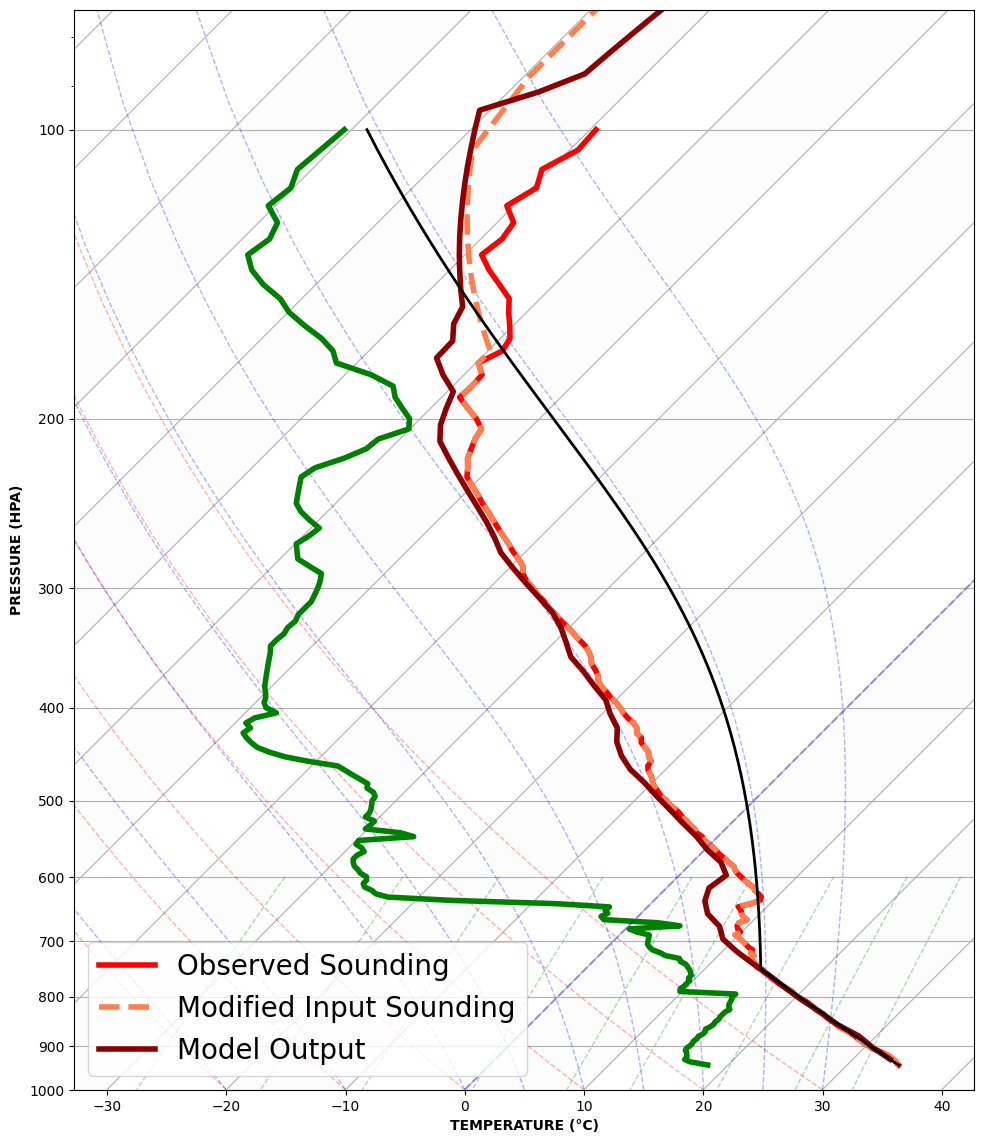

In [33]:
#Plot the modified sounding
#Plot the unchanged sounding

# STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A
# NICE, CLEAN PLOT
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))

# add the Metpy logo
#add_metpy_logo(fig, 105, 85, size='small')

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 75)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({obs_temp.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({obs_pres.units:~P})'), weight='bold')

# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO
# INCREASE READABILITY
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# Set the linewidth to 4 for increased readability.
# We will also add the 'label' keyword argument for our legend.
skew.plot(obs_pres, obs_temp, 'r', lw=4, label='Observed Sounding')
skew.plot(obs_pres, obs_dew, 'g', lw=4)
skew.plot(pres_extr, temp_extr, 'coral', lw=4, ls = '--', label = 'Modified Input Sounding')
skew.plot(prs_hpa_lo, temp_lo, color = 'darkred', lw = 4, label = 'Model Output')


# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first, we add a matplotlib axvline to highlight the 0-degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as a black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from a low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(obs_pres, obs_temp[0], obs_dew[0]).to('degC')
skew.plot(obs_pres, prof, 'k', linewidth=2)
skewleg = skew.ax.legend(loc='lower left', fontsize = 20)




In [34]:
mixing = mix_rat_extr
theta = theta_extr

In [35]:
surf_pres = pres_extr[0].magnitude
surf_theta = theta[0].magnitude
surf_mr = mixing[0].magnitude

In [37]:
input_sounding = pd.DataFrame([alt_extr[1:].magnitude, theta[1:].magnitude, mixing[1:].magnitude, u_extr[1:].magnitude, v_extr[1:].magnitude])
top_row = pd.DataFrame([surf_pres, surf_theta, surf_mr])

In [38]:
append_sound = pd.concat([top_row, input_sounding]).reset_index(drop=True)